# XGBoost Parameter Tuning
In this notebook, I do a comprehensive parameter tuning on the Gradient Boosting model to increase performance, doing grid searches across hyperparameters, and applying early stoppage to reduce overfitting.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('ExtractedFinalDataset.csv')

In [3]:
bad_features = []
for i in range(8):
    langevin = str(i) + "__max_langevin_fixed_point__m_3__r_30"
    bad_features.append(langevin)
    for j in range(9):
        quantile = (j+1)*0.1
        if quantile != 0.5:
            feature_name = str(i) + "__index_mass_quantile__q_" + str(quantile)
            bad_features.append(feature_name)

In [4]:
df = df.drop(bad_features, axis=1)

In [5]:
df.index = df['9']
df = df.drop(['9'], axis=1)
df['Label'] = "One"
df['Label'][2001.0 <= df.index ] = "Two"
df['Label'][4001.0 <= df.index ] = "Three"
df['Label'][6001.0 <= df.index ] = "Four"
df['Label'][8001.0 <= df.index ] = "Five"
df['Label'][10001.0 <= df.index ] = "Six"

In [6]:
df = df[1:]

In [7]:
df.columns = df.columns.map(lambda t: str(t))
df = df.sort_index(axis=1)

In [8]:
extracted_features = df

In [9]:
subsample = extracted_features.sample(frac=0.02).reset_index(drop=True)
subsample.shape

(240, 1705)

In [10]:
X = subsample.drop(['Label'], 1)
y = subsample['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
import xgboost as xgb
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [13]:
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [14]:
optimized_GBM.grid_scores_

[mean: 0.66667, std: 0.05789, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.65476, std: 0.02326, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.65476, std: 0.04901, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.66071, std: 0.05527, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.67262, std: 0.03596, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.66667, std: 0.03882, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.67262, std: 0.03976, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.67262, std: 0.03596, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.66667, std: 0.03882, params: {'max_depth': 7, 'min_child_weight': 5}]

Individually tuning some XGBoost Parameters until we find the best combination since gridsearch will take too long at this point.

In [11]:
model = xgboost.XGBClassifier(learning_rate =0.05,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.722222222222


In [12]:
model = xgboost.XGBClassifier(learning_rate =0.05,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.763888888889


Incredibly impressive accuracy for only using 2% of the training set.

In [13]:
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.763888888889


In [14]:
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.777777777778


In [15]:
model = xgboost.XGBClassifier(learning_rate =0.2,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.777777777778


In [17]:
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=3000,
 max_depth=7,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.5,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.777777777778


In [18]:
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=3000,
 max_depth=7,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.5,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.736111111111


In [19]:
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=3000,
 max_depth=7,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.75


In [20]:
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=3000,
 max_depth=7,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.01,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.763888888889


In [21]:
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=3000,
 max_depth=7,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.763888888889


Okay, it seems like our best set of parameters are doing pretty well. Let's see how much accuracy we lose by reducing our estimators.

In [22]:
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.5,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train), np.array(y_train))

print 'Training accuracy:', model.score(np.array(X_train), np.array(y_train))
print 'Test accuracy:', model.score(np.array(X_test), np.array(y_test))

Training accuracy: 1.0
Test accuracy: 0.722222222222


Quite a lot. Time to validate a 70-30 split on our full dataset using our best parameters to get an idea of how this ensemble algorithm will perform.

In [26]:
fullset = extracted_features.sample(frac=1).reset_index(drop=True)
X = fullset.drop(['Label'], 1)
y = fullset['Label']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
model = xgboost.XGBClassifier(learning_rate =0.05,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.5,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=27)

model.fit(np.array(X_train_full), np.array(y_train_full))

print 'Training accuracy:', model.score(np.array(X_train_full), np.array(y_train_full))
print 'Test accuracy:', model.score(np.array(X_test_full), np.array(y_test_full))

Training accuracy: 1.0
Test accuracy: 0.840100111235


Doing some early stopping analysis and parameter fine-tuning for overfitting prevention on the gradient boost.

[0]	validation_0-merror:0.262336	validation_0-mlogloss:1.64032	validation_1-merror:0.296162	validation_1-mlogloss:1.6503
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.226103	validation_0-mlogloss:1.51914	validation_1-merror:0.265295	validation_1-mlogloss:1.53864
[2]	validation_0-merror:0.212515	validation_0-mlogloss:1.41889	validation_1-merror:0.259455	validation_1-mlogloss:1.44504
[3]	validation_0-merror:0.198927	validation_0-mlogloss:1.32935	validation_1-merror:0.246941	validation_1-mlogloss:1.36246
[4]	validation_0-merror:0.195709	validation_0-mlogloss:1.25277	validation_1-merror:0.238598	validation_1-mlogloss:1.29217
[5]	validation_0-merror:0.191538	validation_0-mlogloss:1.18602	validation_1-merror:0.234983	validation_1-mlogloss:1.23032
[6]	validation_0-merror:0.188319	validation_0-mlogloss:1.12559	validation_1-merror:0.229978	validation

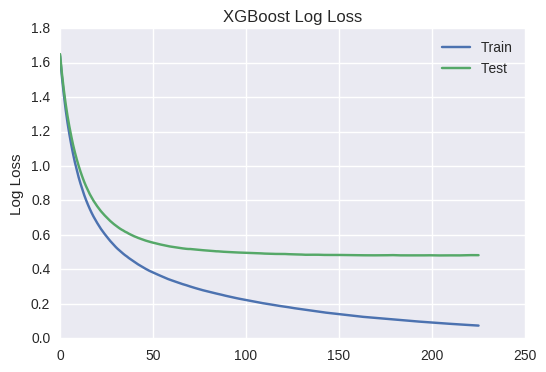

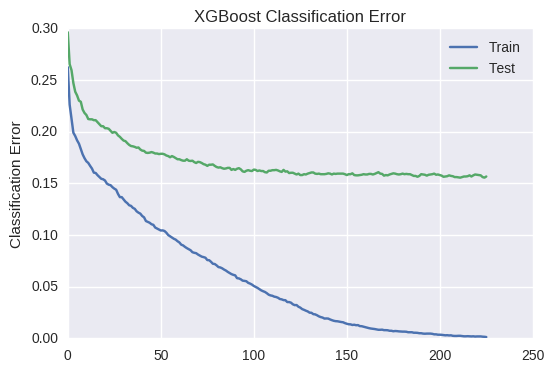

In [46]:
from sklearn.metrics import accuracy_score
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.5,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=22)
evaluation_set = [(X_train_full, y_train_full), (X_test_full, y_test_full)]
model.fit(X_train_full, y_train_full, eval_metric=["merror", "mlogloss"], eval_set=evaluation_set,early_stopping_rounds=20, verbose=True)

y_predictions = model.predict(X_test_full)
# evaluate predictions
accuracy = accuracy_score(y_test_full, y_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

[0]	validation_0-merror:0.262336	validation_0-mlogloss:1.64032	validation_1-merror:0.296162	validation_1-mlogloss:1.6503
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.226103	validation_0-mlogloss:1.51914	validation_1-merror:0.265295	validation_1-mlogloss:1.53864
[2]	validation_0-merror:0.212515	validation_0-mlogloss:1.41895	validation_1-merror:0.259455	validation_1-mlogloss:1.44512
[3]	validation_0-merror:0.198927	validation_0-mlogloss:1.32952	validation_1-merror:0.246663	validation_1-mlogloss:1.3627
[4]	validation_0-merror:0.195709	validation_0-mlogloss:1.25292	validation_1-merror:0.238598	validation_1-mlogloss:1.29238
[5]	validation_0-merror:0.191538	validation_0-mlogloss:1.18611	validation_1-merror:0.234705	validation_1-mlogloss:1.23049
[6]	validation_0-merror:0.188439	validation_0-mlogloss:1.12566	validation_1-merror:0.229978	validation_

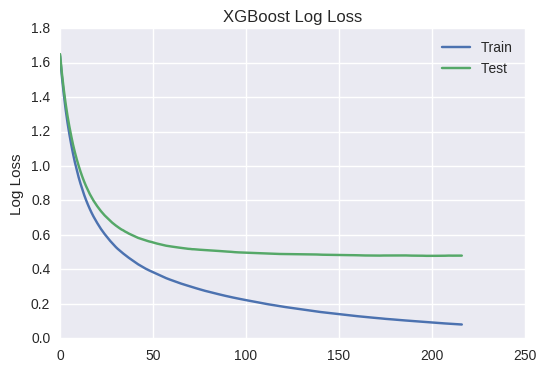

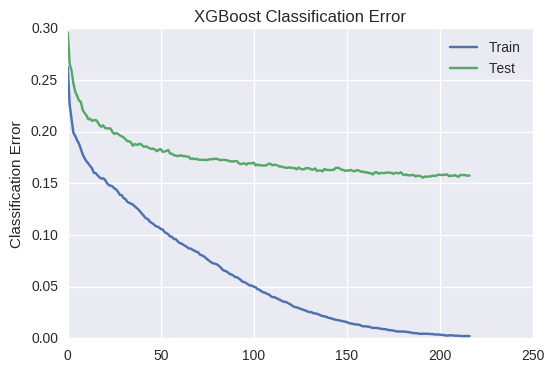

In [47]:
from sklearn.metrics import accuracy_score
model = xgboost.XGBClassifier(learning_rate =0.1,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'multi:softmax',
 nthread=8,
 scale_pos_weight=1,
 seed=22)
evaluation_set = [(X_train_full, y_train_full), (X_test_full, y_test_full)]
model.fit(X_train_full, y_train_full, eval_metric=["merror", "mlogloss"], eval_set=evaluation_set,early_stopping_rounds=20, verbose=True)

y_predictions = model.predict(X_test_full)
# evaluate predictions
accuracy = accuracy_score(y_test_full, y_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()